<a href="https://colab.research.google.com/github/AnnaVitali/plantRecognition/blob/develop/plantRecognition_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download training set

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Saving kaggle.json to kaggle.json
ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset                Hotel Reservations Dataset                          480KB  2023-01-04 12:50:31           7399        262  1.0              
themrityunjaypathak/most-subscribed-1000-youtube-channels        Most Subscribed 1000 Youtube Channels                28KB  2023-01-21 14:42:05           1423         51  1.0              
senapatirajesh/netflix-tv-shows-and-movies                       Latest Netflix TV shows and movies                    1MB  2023-01-14 17:03:12           2773         73  0.9411765        
ulrikthygepedersen/on

In [ ]:
! unzip new-plant-diseases-dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New P

# Import

In [ ]:
import os
import glob
import re
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import random
import shutil
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import interact, fixed
import ipywidgets as widgets
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import img_to_array
from keras.layers.reshaping.flatten import Flatten
from keras.models import Model
from keras.layers import Dense
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
%tensorflow_version 2.x

!pip uninstall -y h5py
!pip install h5py==2.10.0

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 74.7 MB/s eta 0:00:00


# Utilies

In [ ]:
class_names = ['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']

In [ ]:
def organize_data(data_folder_path, data_folder):
  class_folder_path_list = glob.glob(data_folder_path + '/*/')
  if not os.path.exists(data_folder):
    os.mkdir(data_folder)
  count = 0;
  for class_folder_path in class_folder_path_list:
        class_folder_path=class_folder_path.replace('\\','/')
        folder_label=os.path.basename(class_folder_path.split('_', 1)[0])
        destination_folder = data_folder + '/'+ folder_label
        if not os.path.exists(destination_folder):
          os.mkdir(destination_folder)
        for image_file_path in glob.glob(class_folder_path+'/*'):
            image_file_path=image_file_path.replace('\\','/')
            shutil.copy(image_file_path, destination_folder + '/' + str(count) + '.jpg')
            count = count + 1

# Caricamento dataset

In [ ]:
db_path_train = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
db_path_valid = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
train_data_folder = '/content/train'
valid_data_folder = '/content/valid'

organize_data(db_path_train, train_data_folder)
organize_data(db_path_valid, valid_data_folder)

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    train_data_folder,
    labels="inferred",
    seed=1337,
    image_size=(64, 64)
)

valid = tf.keras.utils.image_dataset_from_directory(
    valid_data_folder,
    validation_split = 0.3,
    subset="training",
    labels="inferred",
    seed=1337,
    image_size=(64, 64)
)

test = tf.keras.utils.image_dataset_from_directory(
    valid_data_folder,
    validation_split = 0.3,
    subset="validation",
    labels="inferred",
    seed=1337,
    image_size=(64, 64)
)


Found 70295 files belonging to 14 classes.
Found 17572 files belonging to 14 classes.
Using 12301 files for training.
Found 17572 files belonging to 14 classes.
Using 5271 files for validation.


# Visualizzazione immagini

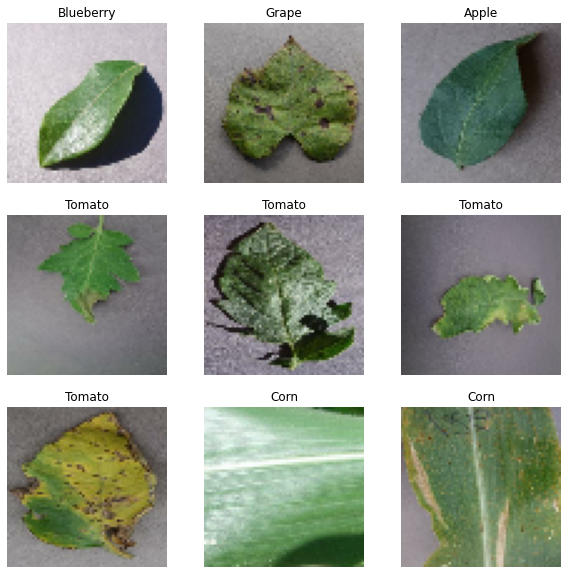

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Addestramento del modello

In [ ]:
pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
print(pre_trained_model.summary())

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

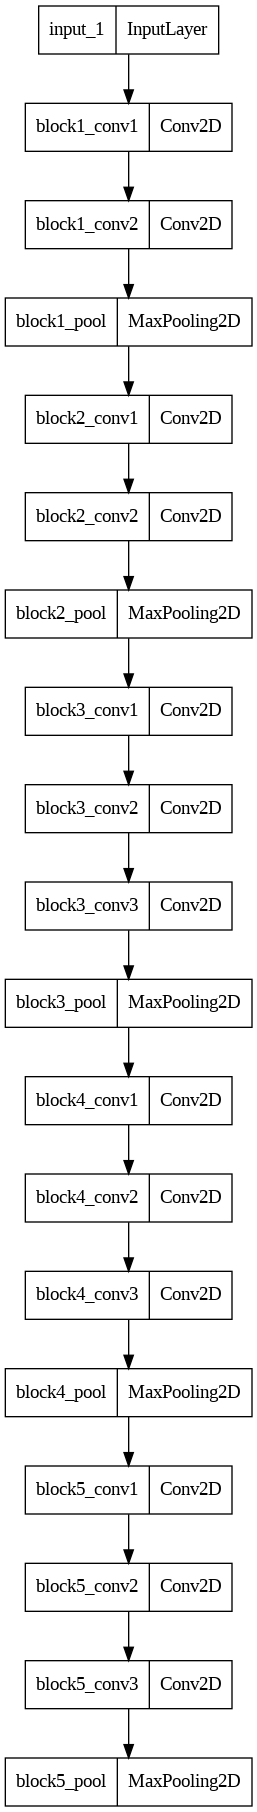

In [ ]:
plot_model(pre_trained_model, to_file='vgg.png')

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

model = keras.models.Sequential()
model.add(pre_trained_model)
model.add(Flatten())
model.add(Dense(len(class_names), activation='softmax'))

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer = "adam", #tf.keras.optimizers.SGD(learning_rate=0.01, name="SGD"),
    metrics = ["accuracy"]
)

print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

model.summary()

Inputs: [<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'vgg16_input')>]
Outputs: [<KerasTensor: shape=(None, 14) dtype=float32 (created by layer 'dense')>]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 14)                28686     
                                                                 
Total params: 14,743,374
Trainable params: 28,686
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(train, validation_data = valid, epochs = 3)

Epoch 1/3
2197/2197 [==============================] - 66s 27ms/step - loss: 1.4504 - accuracy: 0.8387 - val_loss: 1.0886 - val_accuracy: 0.8756
Epoch 2/3
2197/2197 [==============================] - 58s 26ms/step - loss: 0.8312 - accuracy: 0.9015 - val_loss: 1.1179 - val_accuracy: 0.8880
Epoch 3/3
2197/2197 [==============================] - 53s 24ms/step - loss: 0.7300 - accuracy: 0.9165 - val_loss: 1.0860 - val_accuracy: 0.9037


In [ ]:
#Saving our model
filepath="model.h5"
model.save(filepath)

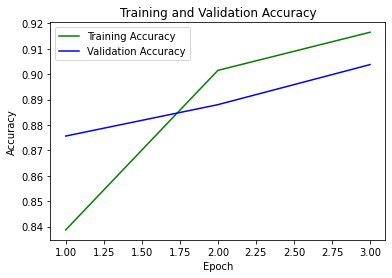

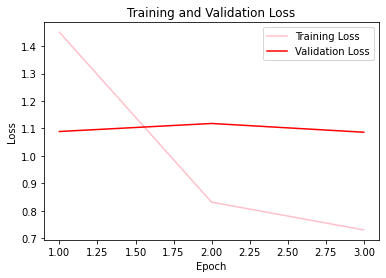

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Predizioni sul test set

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in tqdm(test):
  pred =  model.predict(x, verbose=False).argmax(axis=-1)
  predictions = np.concatenate([predictions,pred])
  labels = np.concatenate([labels, y])

  0%|          | 0/165 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       Apple       0.82      0.85      0.84       600
   Blueberry       0.87      0.84      0.85       123
      Cherry       0.98      0.73      0.84       278
        Corn       0.99      0.98      0.98       548
       Grape       0.94      0.96      0.95       528
      Orange       0.95      0.93      0.94       166
       Peach       0.90      0.90      0.90       263
     Pepper,       0.82      0.88      0.85       304
      Potato       0.78      0.92      0.84       436
   Raspberry       0.86      0.97      0.91       130
     Soybean       0.93      0.89      0.91       149
      Squash       0.97      0.98      0.98       129
  Strawberry       0.97      0.87      0.92       268
      Tomato       0.92      0.90      0.91      1349

    accuracy                           0.90      5271
   macro avg       0.91      0.90      0.90      5271
weighted avg       0.91      0.90      0.90      5271



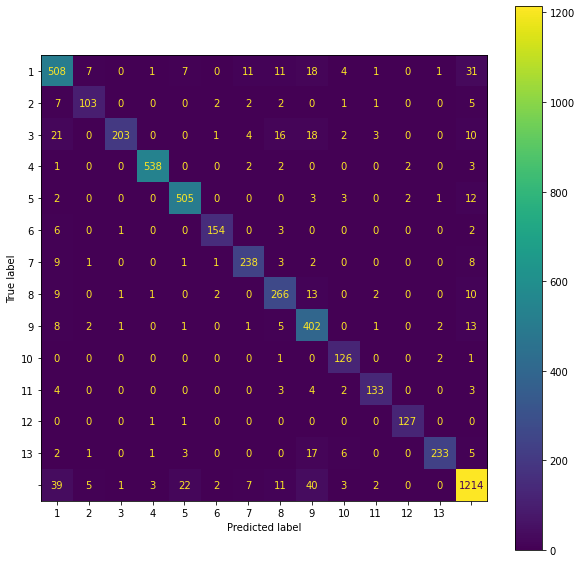

In [ ]:
print(classification_report(labels, predictions, target_names=class_names))

matrix = confusion_matrix(labels, predictions)
diagonal = matrix.diagonal()/matrix.sum(axis=1)

# Mostriamo la matrice di confusione
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(len(class_names))))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)